In [58]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt

In [59]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [60]:
train = train.dropna(subset=['portId'])
print(train.shape)
# Verify the result by checking the count of missing values
print("Number of missing values in each column after dropping rows with NaN in 'portId':")
print(train.isna().sum())

(1520450, 11)
Number of missing values in each column after dropping rows with NaN in 'portId':
time         0
cog          0
sog          0
rot          0
heading      0
navstat      0
etaRaw       0
latitude     0
longitude    0
vesselId     0
portId       0
dtype: int64


In [61]:
schedules = pd.read_csv('data/datasets/schedules_to_may_2024.csv', sep='|')

In [62]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)
schedules['portId'] = schedules['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)
schedules['vesselId'] = schedules['vesselId'].map(vessel_id_mapping)


shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)
schedules['shippingLineId'] = schedules['shippingLineId'].map(shipping_line_id_mapping)

In [63]:
import pytz
schedules['sailingDate'] = pd.to_datetime(schedules['sailingDate'], errors='coerce')
schedules['arrivalDate'] = pd.to_datetime(schedules['arrivalDate'], errors='coerce')

# Convert sailingDate and arrivalDate to a different timezone, such as CET (Central European Time)
# Convert datetime columns to timezone-naive format by removing timezone info
schedules['sailingDate'] = schedules['sailingDate'].dt.tz_convert(None)
schedules['arrivalDate'] = schedules['arrivalDate'].dt.tz_convert(None)


schedules.head()


,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-02,2023-10-03,Port of Brunswick,121.0,31.140556,-81.496667
1,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-27,2023-10-27,Port of Southampton,56.0,50.902500,-1.428889
2,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-19,2023-10-20,Port of Bremerhaven,38.0,53.563611,8.554722
3,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-09,2023-10-10,Port of New York,159.0,40.688333,-74.028611
4,71.0,5,Wallenius Wilhelmsen Ocean,2023-09-25,2023-09-26,Manzanillo International Terminal,364.0,9.372370,-79.879790


In [64]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,64.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,254.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,67.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [65]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


In [ ]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'breadth', 'GT']], on='vesselId', how='left')
# train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

num_maxSpeed_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_maxSpeed_nan}")
train.head()

Number of NaN values in maxSpeed: 14949


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,breadth,GT
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,32.00,57718
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,32.26,59583
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,32.00,59217
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,32.00,55598
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,32.20,58939


KeyboardInterrupt: 

In [ ]:
# Calculate the mean breadth for shipping line 5
mean_breadth_shipping_line_5 = train[train['shippingLineId'] == 5]['breadth'].mean()

# Impute missing breadth with the calculated mean
train.loc[train['shippingLineId'] == 5, 'breadth'] = train.loc[train['shippingLineId'] == 5, 'breadth'].fillna(mean_breadth_shipping_line_5)

# Verify if the missing values were filled
missing_count_after_imputation = train['breadth'].isnull().sum()
print(f"Missing Breadth values after imputation: {missing_count_after_imputation}")


Missing Breadth values after imputation: 0


In [ ]:
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520450 entries, 0 to 1520449
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   time            1520450 non-null  datetime64[ns]
 1   cog             1520450 non-null  float64       
 2   sog             1520450 non-null  float64       
 3   rot             1520450 non-null  int64         
 4   heading         1520450 non-null  int64         
 5   navstat         1520450 non-null  int64         
 6   etaRaw          1520450 non-null  object        
 7   latitude        1520450 non-null  float64       
 8   longitude       1520450 non-null  float64       
 9   vesselId        1520450 non-null  int64         
 10  portId          1520450 non-null  int64         
 11  latitude_port   1520450 non-null  float64       
 12  longitude_port  1520450 non-null  float64       
 13  length          1520450 non-null  float64       
 14  shippingLineId  15


Minimum required date:
2024-05-07 23:59:08


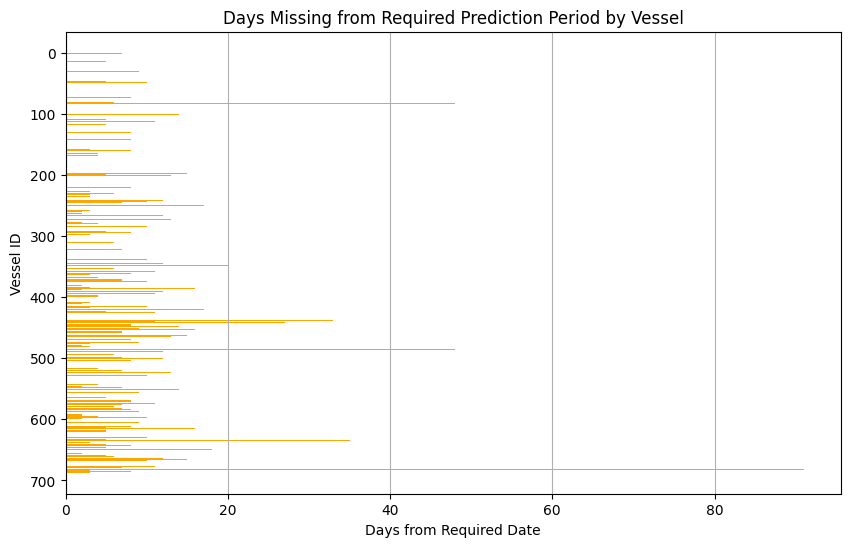

In [ ]:
df_days_before_prediction = train.copy()
# Ensure 'time' column is in datetime format
df_days_before_prediction['time'] = pd.to_datetime(df_days_before_prediction['time'])


# Specify the year to append
current_year = 2024  # Change to the desired year

# Modify etaRaw to include the year
df_days_before_prediction['etaRaw'] = df_days_before_prediction['etaRaw'].apply(lambda x: f"{current_year}-{x}")


# Convert 'etaRaw' column to datetime
df_days_before_prediction['etaRaw'] = pd.to_datetime(df_days_before_prediction['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')

# Define the start of the prediction period and calculate minimum required date
prediction_start_date = df_days_before_prediction['time'].max()
days_before_start = 0  # Set to the number of days you want before the start date
min_required_date = prediction_start_date 

# Get the last recorded date for each vessel along with `etaRaw`
vessel_last_dates = df_days_before_prediction.groupby('vesselId').agg({'time': 'max', 'etaRaw': 'last'}).reset_index()
vessel_last_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Check the minimum required date
print("\nMinimum required date:")
print(min_required_date)

# Add a new column to indicate if etaRaw is before the minimum required date
vessel_last_dates['etaRaw_before_required'] = vessel_last_dates['etaRaw'] < min_required_date

# Calculate days missing from the required date
vessel_last_dates['days_from_required'] = (min_required_date - vessel_last_dates['last_train_time']).dt.days

# Add a new column to indicate if the data is before the required date
vessel_last_dates['before_required_date'] = vessel_last_dates['days_from_required'] > 1

# Separate vessels with incomplete data
vessels_with_incomplete_data = vessel_last_dates[vessel_last_dates['before_required_date']]

# Plot vessels with incomplete data
plt.figure(figsize=(10, 6))
plt.barh(vessels_with_incomplete_data['vesselId'], vessels_with_incomplete_data['days_from_required'], color='orange')
plt.xlabel('Days from Required Date')
plt.ylabel('Vessel ID')
plt.title('Days Missing from Required Prediction Period by Vessel')
plt.gca().invert_yaxis()  # Invert y-axis to have the vessel with the most missing days on top
plt.grid(axis='x')  # Add gridlines for better readability
plt.show()



In [ ]:
# Define the minimum required date for predictions in the test set
min_required_date = test['time'].min() # 5 days before the earliest test date
print(f"Minimum required date for predictions: {min_required_date}")

# Filter the schedules DataFrame based on the required date
schedules_filtered = schedules[~((schedules['sailingDate'] < min_required_date) & 
                                  (schedules['arrivalDate'] < min_required_date))]

# Get the last recorded date for each vessel in the training set
last_train_dates = train.groupby('vesselId')['time'].max().reset_index()
last_train_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Print the filtered schedules for verification
# print("Filtered schedules:")
# print(schedules_filtered.head())

# Filter vessels that are in the test set
vessels_in_test = test['vesselId'].unique()
missing_days_df = last_train_dates[last_train_dates['vesselId'].isin(vessels_in_test)].copy()

# Calculate the days missing for each vessel from the required date
missing_days_df['days_missing'] = (min_required_date - missing_days_df['last_train_time']).dt.days

# Filter vessels missing a significant number of days (e.g., more than 2 days)
significant_gap_vessels = missing_days_df[missing_days_df['days_missing'] > 1]

# Print the vessels with significant gaps
print("Vessels in the test set missing significant data before prediction date:")
print(significant_gap_vessels[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days: {len(significant_gap_vessels)}")

# Optional: If you want to check which vessels are in filtered schedules
vessels_in_filtered_schedules = schedules_filtered['vesselId'].unique()
print(f"Number of unique vessels in filtered schedules: {len(vessels_in_filtered_schedules)}")

# Step to find which significant gap vessels are in filtered schedules
vessels_in_gap_and_schedule = set(significant_gap_vessels['vesselId']).intersection(vessels_in_filtered_schedules)

# Create a DataFrame for common vessels with significant gaps in schedules
vessels_in_gap_and_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_and_schedule)]


# Print results
print("Vessels with significant gaps that are also in the filtered schedules:")
print(vessels_in_gap_and_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are in schedules: {len(vessels_in_gap_and_schedule_df)}")

Minimum required date for predictions: 2024-05-03 00:03:16
Vessels in the test set missing significant data before prediction date:
     vesselId     last_train_time  days_missing
3           3 2024-04-26 13:29:25             6
30         30 2024-04-28 19:17:28             4
79         79 2024-04-28 04:45:55             4
80         80 2024-04-23 23:00:00             9
243       243 2024-04-27 21:40:48             5
344       344 2024-04-24 07:16:53             8
352       352 2024-04-29 00:05:23             3
358       358 2024-04-26 13:50:08             6
367       367 2024-04-30 07:08:07             2
378       378 2024-04-11 05:44:29            21
385       385 2024-04-30 22:02:25             2
528       528 2024-04-27 13:07:07             5
548       548 2024-04-30 18:39:21             2
574       574 2024-04-26 07:36:18             6
587       587 2024-04-28 23:44:44             4
615       615 2024-04-21 08:15:03            11
632       632 2024-04-29 18:08:30             3
647 

In [ ]:

# Step to find which significant gap vessels are NOT in filtered schedules
vessels_in_gap_not_in_schedule = set(significant_gap_vessels['vesselId']).difference(vessels_in_filtered_schedules)

# Create a DataFrame for vessels with significant gaps that are not in the schedules
vessels_in_gap_not_in_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_not_in_schedule)]

# Print results
print("Vessels with significant gaps that are NOT in the filtered schedules:")
print(vessels_in_gap_not_in_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are NOT in schedules: {len(vessels_in_gap_not_in_schedule_df)}")

Vessels with significant gaps that are NOT in the filtered schedules:
     vesselId     last_train_time  days_missing
30         30 2024-04-28 19:17:28             4
80         80 2024-04-23 23:00:00             9
344       344 2024-04-24 07:16:53             8
352       352 2024-04-29 00:05:23             3
358       358 2024-04-26 13:50:08             6
378       378 2024-04-11 05:44:29            21
385       385 2024-04-30 22:02:25             2
528       528 2024-04-27 13:07:07             5
587       587 2024-04-28 23:44:44             4
615       615 2024-04-21 08:15:03            11
632       632 2024-04-29 18:08:30             3
647       647 2024-04-26 22:05:53             6
675       675 2024-04-12 06:09:24            20
Number of vessels with significant missing days that are NOT in schedules: 13


In [ ]:
schedules_filtered.head()

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
8,616.0,0,Hoegh Autoliners,2024-06-02 10:00:00,2024-06-04 10:00:00,Port of Durban,170.0,-29.881111,31.027222
9,616.0,0,Hoegh Autoliners,2024-05-18 22:15:00,2024-05-18 22:30:00,Port of Sohar,243.0,24.378333,56.740556
10,616.0,0,Hoegh Autoliners,2024-05-16 19:00:00,2024-05-16 22:00:00,Port of Shuaiba,509.0,29.044722,48.159722
11,616.0,0,Hoegh Autoliners,2024-07-07 10:00:00,2024-07-08 08:30:00,Port of Jacksonville,41.0,30.380833,-81.564444
13,616.0,0,Hoegh Autoliners,2024-06-23 10:00:00,2024-06-24 10:00:00,Port of Kingston,306.0,17.981667,-76.829444


In [ ]:
print(train.head())
print(train.info())
print("Number of missing values in each column:\n", train.isnull().sum())

                 time    cog   sog  rot  heading  navstat       etaRaw  \
0 2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1 2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2 2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3 2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4 2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   

   latitude  longitude  vesselId  portId  latitude_port  longitude_port  \
0 -34.74370  -57.85130         0       0       -33.5875      -71.618889   
1   8.89440  -79.47939         1       1         8.9670      -79.533000   
2  39.19065  -76.47567         2       2        39.2325      -76.558889   
3 -34.41189  151.02067         3       3       -34.4625      150.899444   
4  35.88379   -5.91636         4       4        35.7830       -5.817000   

   length  shippingLineId  breadth     GT  
0  199.00               9    32.00  57718  
1  199.97       

In [ ]:
def create_five_day_windows(df):
    # Ensure that 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort data to ensure time sequence within each vessel
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    windows = []

    for vessel_id, group in df.groupby('vesselId'):
        group = group.sort_values(by='time')
        unique_dates = group['time'].dt.date.unique()

        # Start index for the window
        start_idx = 0
        
        while start_idx < len(unique_dates):
            # Determine the end index for the current window, allowing up to 5 days
            end_idx = min(start_idx + 5, len(unique_dates))  # Allow up to 5 days
            start_date = unique_dates[start_idx]
            end_date = unique_dates[end_idx - 1]  # Last day in the current window

            # Select data within the current window
            window = group[(group['time'].dt.date >= start_date) & (group['time'].dt.date <= end_date)]

            # If there are no rows in the window, we can skip to the next unique date
            if len(window) == 0:
                start_idx += 1
                continue
            
            # Reference row: the first row in the window
            reference_row = window.iloc[0]

            # Append each row in this window with reference features from the first row
            for _, row in window.iterrows():
                windows.append({
                    'vesselId': row['vesselId'],
                    'time': row['time'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    # 'latitude_port': row['latitude_port'],
                    # 'longitude_port': row['longitude_port'],
                    'cog_sin': row['cog_sin'],
                    'cog_cos': row['cog_cos'],
                    'cog': row['cog'],
                    'sog': row['sog'],
                    'rot': row['rot'],
                    'under_way': row['under_way'],
                    'length': row['length'],
                    'breadth': row['breadth'],
                    'GT': row['GT'],
                    # Features based on the first row in the window
                    'latitude_first': reference_row['latitude'],
                    'longitude_first': reference_row['longitude'],
                    'cog_sin_first': reference_row['cog_sin'],
                    'cog_cos_first': reference_row['cog_cos'],
                    'sog_first': reference_row['sog'],
                    # 'rot_first': reference_row['rot'],
                    'under_way_first': reference_row['under_way'],
                    'time_since_start': (row['time'] - reference_row['time']).total_seconds()
                })

            # Move to the next start index (no overlap)
            start_idx += 5  # Increment by 5 to avoid overlap, allowing for the next window to start after the current one
            
    return pd.DataFrame(windows)


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

In [ ]:
from shapely.geometry import Point, MultiPoint
import pandas as pd
import numpy as np

def incremental_convex_hull(df):
    points = []
    areas = []

    for idx, row in df.iterrows():
        point = Point(row['longitude'], row['latitude'])
        points.append(point)

        if len(points) < 3:
            areas.append(0.0)
        else:
            # Calculate convex hull for the current set of points
            multipoint = MultiPoint(points)
            hull = multipoint.convex_hull
            areas.append(hull.area)

    return areas

In [ ]:
def future_position(lat, lon, cog, sog, time_diff):
    """
    Calculate the future position given the current latitude, longitude, COG, SOG, and time difference in seconds.
    """
    # Convert COG from degrees to radians
    cog_rad = np.radians(cog)

    # Calculate distance traveled in meters
    distance = sog * time_diff  # distance = speed * time

    # Calculate future latitude and longitude
    future_lat = lat + (distance * np.cos(cog_rad)) / 111320  # 111320 meters per degree latitude
    future_lon = lon + (distance * np.sin(cog_rad)) / (111320 * np.cos(np.radians(lat)))  # adjust for longitude

    return future_lat, future_lon

### Feature engineering 

In [ ]:
def feature_engineering(train):
    train = train.copy()
    train = train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    # # Handle NaNs
    # train[['latitude', 'longitude', 'cog', 'time']] = (
    #     train.groupby('vesselId')[['latitude', 'longitude', 'cog', 'time']].apply(lambda x: x.ffill().bfill())
    # ).reset_index(drop=True)

    features = pd.DataFrame()
    features['vesselId'] = train['vesselId']
    features['time'] = train['time'] 
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['rot'] = train['rot']
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)
    features['cog_rad'] = np.radians(features['cog'])
    features['cog_sin'] = np.sin(features['cog_rad'])
    features['cog_cos'] = np.cos(features['cog_rad'])
    features['length'] = train['length']
    features['breadth'] = train['breadth']
    features['GT'] = train['GT']
    # features['latitude_port'] = train['latitude_port']
    # features['longitude_port'] = train['longitude_port']
    
    features = create_five_day_windows(features)
    print("Features columns after window creation:", features.columns)

    
    # # Calculate area covered incrementally
    # features['area_covered'] = features.groupby('vesselId').apply(
    #     lambda group: incremental_convex_hull(group)
    # ).explode().reset_index(drop=True)

    # # Convert area to numeric
    # features['area_covered'] = pd.to_numeric(features['area_covered'], errors='coerce')

    features['distance_to_port'] = haversine(features['latitude'], features['longitude'], 
                                              features['latitude_port'], features['longitude_port'])

     # Calculate area covered incrementally
    # features['area_covered'] = features.groupby('vesselId').apply(incremental_convex_hull).reset_index(drop=True)

    # # Convert area to numeric
    # features['area_covered'] = pd.to_numeric(features['area_covered'], errors='coerce')
    
    # features['time_diff'] = features.groupby('vesselId')['time'].diff().dt.total_seconds().fillna(0)

    # # Calculate future positions
    # future_positions = features.apply(lambda row: future_position(
    #     row['latitude'], row['longitude'], row['cog'], row['sog'], row['time_diff']), axis=1)

    # features['future_latitude'], features['future_longitude'] = zip(*future_positions)
    
    # features['area_covered'] = features.apply(lambda row: calculate_convex_hull_area(
    #     features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['latitude'].tolist(),
    #     features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['longitude'].tolist()), axis=1)

    # Calculate cumulative area covered for each vessel
    # features['cumulative_area_covered'] = features.groupby('vesselId')['area_covered'].cumsum()
 
    # Additional time-based features
    features['month'] = features['time'].dt.month
    features['day'] = features['time'].dt.day
    features['hour'] = features['time'].dt.hour
    features['minute'] = features['time'].dt.minute
    # features['day_of_week'] = features['time'].dt.dayofweek

    return features

training_data = train
features = feature_engineering(training_data)

KeyboardInterrupt: 

In [ ]:
train_features = features.copy()

In [ ]:
# nan_values = train_features.isnull().sum()
# print(nan_values)


# Drop the columns 'time' and 'rot'
train_features= train_features.drop(columns=['time', ])

nan_values = train_features.isnull().sum()
print(nan_values)

vesselId            0
latitude            0
longitude           0
cog_sin             0
cog_cos             0
cog                 0
sog                 0
rot                 0
under_way           0
length              0
breadth             0
GT                  0
latitude_first      0
longitude_first     0
cog_sin_first       0
cog_cos_first       0
sog_first           0
under_way_first     0
time_since_start    0
month               0
day                 0
hour                0
minute              0
dtype: int64


In [ ]:
train_features = train_features.dropna()



In [ ]:
train_features.tail()

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,longitude_first,cog_sin_first,cog_cos_first,sog_first,under_way_first,time_since_start,month,day,hour,minute
1520445,687,37.06484,144.66435,0.872069,0.489382,60.7,16.0,0,1,164.0,...,143.51977,0.85896,0.512043,16.9,1,14400.0,5,4,4,14
1520446,687,37.11041,144.76165,0.849893,0.526956,58.2,15.7,0,1,164.0,...,143.51977,0.85896,0.512043,16.9,1,15623.0,5,4,4,35
1520447,687,37.15745,144.85164,0.845262,0.534352,57.7,15.4,0,1,164.0,...,143.51977,0.85896,0.512043,16.9,1,16806.0,5,4,4,55
1520448,687,37.20409,144.94732,0.854459,0.519519,58.7,15.1,0,1,164.0,...,143.51977,0.85896,0.512043,16.9,1,18072.0,5,4,5,16
1520449,687,37.22231,144.98452,0.864275,0.503020,59.8,14.9,0,1,164.0,...,143.51977,0.85896,0.512043,16.9,1,18576.0,5,4,5,24


In [ ]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(train_features)
# last_features.drop(columns=['DWT']) 
last_features.head(10)

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,longitude_first,cog_sin_first,cog_cos_first,sog_first,under_way_first,time_since_start,month,day,hour,minute
0,0,34.57936,128.99926,-0.662620,-0.748956,221.5,15.5,0,1,199.00,...,-122.38260,0.816138,-0.577858,0.0,0,1254344.0,5,1,12,41
1,1,1.24460,103.39997,-0.818150,0.575005,305.1,15.7,11,1,199.97,...,103.89888,0.260505,-0.965473,0.0,0,35620.0,4,30,10,12
2,2,18.13873,-69.74863,0.069756,-0.997564,176.0,0.4,0,1,199.00,...,-81.11300,-0.992546,0.121869,15.5,1,427475.0,5,7,23,59
3,3,41.64055,143.29942,0.999123,0.041876,87.6,14.4,0,1,199.00,...,125.83660,0.872922,0.487860,9.7,1,455585.0,4,26,13,29
4,4,26.58710,121.27831,0.630676,0.776046,39.1,12.7,0,1,199.95,...,103.85164,-0.325568,0.945519,0.0,0,562766.0,5,7,12,28
5,5,24.92350,-109.76272,0.642788,0.766044,40.0,18.9,0,1,193.00,...,-110.11940,-0.636078,-0.771625,14.4,1,127154.0,5,7,23,58
6,6,41.21686,12.81621,0.837719,-0.546102,123.1,19.6,0,1,200.00,...,15.38995,0.313992,-0.949425,15.9,1,353230.0,5,7,23,57
7,7,1.26255,104.24250,0.994338,0.106264,83.9,13.8,0,1,199.94,...,119.83045,0.061049,-0.998135,15.9,1,1237572.0,5,5,13,21
8,8,-43.53785,172.83522,-0.625243,0.780430,321.3,0.1,0,0,183.00,...,174.78789,-0.848048,-0.529919,0.0,0,171431.0,5,7,23,52
9,9,35.46923,139.68347,0.017452,-0.999848,179.0,0.0,0,0,199.54,...,134.82585,0.933580,0.358368,10.4,1,247300.0,5,7,23,57


### Train the model

In [ ]:
# # Define features and target
y = train_features[['latitude', 'longitude']]  
X = train_features.drop(columns=['latitude', 'longitude']) 
X.head()

,vesselId,cog_sin,cog_cos,cog,sog,rot,under_way,length,breadth,GT,...,longitude_first,cog_sin_first,cog_cos_first,sog_first,under_way_first,time_since_start,month,day,hour,minute
0,0,-0.970296,0.241922,284.0,0.7,0,1,199.0,32.0,57718,...,-57.8513,-0.970296,0.241922,0.7,1,0.0,1,1,0,0
1,0,0.998806,-0.048850,92.8,14.2,0,1,199.0,32.0,57718,...,-57.8513,-0.970296,0.241922,0.7,1,22123.0,1,1,6,9
2,0,0.999962,-0.008727,90.5,14.3,0,1,199.0,32.0,57718,...,-57.8513,-0.970296,0.241922,0.7,1,23874.0,1,1,6,38
3,0,0.999507,0.031411,88.2,14.3,0,1,199.0,32.0,57718,...,-57.8513,-0.970296,0.241922,0.7,1,25110.0,1,1,6,58
4,0,0.999560,0.029666,88.3,12.3,0,1,199.0,32.0,57718,...,-57.8513,-0.970296,0.241922,0.7,1,26131.0,1,1,7,15


In [ ]:
# best_model = RandomForestRegressor(max_depth=50, random_state=42)

# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 300],            # Number of trees in the forest
#     'max_depth': [5, 10, 25, None],             # Maximum depth of the tree
#     'min_samples_split': [2, 5],           # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2],            # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt'],      # The number of features to consider when looking for the best split
#     'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
# }

# # Perform Randomized Search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                                    n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
# random_search.fit(X, y)

# best_model = random_search.best_estimator_

# # Output the best parameters and score
# print(f"Best parameters: {random_search.best_params_}")
# print(f"Best score (negative mean squared error): {-random_search.best_score_}")



# Configure and fit XGBoost model with GPU support
# best_model = RandomForestRegressor(
#     # tree_method='gpu_hist',  # Ensure GPU method is used
#     # n_estimators=1000,       # Increase number of estimators
#     max_depth=25,            # Increase tree depth
#     random_state=42     # Set learning rate
# )

# Fit the model
# best_model.fit(X_train, y_train)

# # Evaluate the model (optional)
# preds = model.predict(X_test)

best_model = xgb.XGBRegressor()

# Fit the model
best_model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:

# Step 1: Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Step 2: Print feature importances
print("Feature Importances:")
print(features_df)

Feature Importances:
             Feature  Importance
11   longitude_first    0.694502
10    latitude_first    0.116934
16  time_since_start    0.064864
12     cog_sin_first    0.014094
14         sog_first    0.010955
13     cog_cos_first    0.010566
7             length    0.010262
1            cog_sin    0.009995
4                sog    0.009946
9                 GT    0.009707
8            breadth    0.009707
15   under_way_first    0.007979
17             month    0.006425
0           vesselId    0.006105
18               day    0.004982
6          under_way    0.004596
3                cog    0.003877
2            cog_cos    0.003671
5                rot    0.000571
19              hour    0.000165
20            minute    0.000096


In [ ]:
X.head()
X.columns

Index(['vesselId', 'cog_sin', 'cog_cos', 'cog', 'sog', 'rot', 'under_way',
       'length', 'breadth', 'GT', 'latitude_first', 'longitude_first',
       'cog_sin_first', 'cog_cos_first', 'sog_first', 'under_way_first',
       'time_since_start', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [ ]:
# # Confirm unique vesselIds in vessels_in_gap_in_schedule
print("Unique vesselIds in vessels_in_gap_in_schedule:")
print(vessels_in_gap_and_schedule_df['vesselId'].unique())
print(f"Count of unique vesselIds: {len(vessels_in_gap_and_schedule_df['vesselId'].unique())}")




Unique vesselIds in vessels_in_gap_in_schedule:
[  3  79 243 367 548 574 679]
Count of unique vesselIds: 7


In [ ]:
matching_vessels = set(last_features['vesselId']).intersection(set(vessels_in_gap_and_schedule_df['vesselId']))
print(f"Number of matching vesselIds: {len(matching_vessels)}")


Number of matching vesselIds: 7


In [ ]:
last_features_gap = last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].copy()
last_features_gap.head()

last_features_gap['under_way'] = 0  # Stationary mode
last_features_gap['sog'] = 0        # Speed over ground to 0
last_features_gap['rot'] = 0        # Rate of turn to 0
last_features_gap['cog'] = 0        # Optional: course over ground to 0
last_features_gap['cog_sin'] = 0    # Sine of course to 0
last_features_gap['cog_cos'] = 1    # Cosine of course to 1
last_features_gap['distance_to_port'] = 0
last_features_gap['time_since_start'] = 0


# Align with the maximum time and date fields in last_features
last_features_gap['day'] = 6 #sunday before 8th of May 
last_features_gap['month'] = last_features['month'].max()
# last_features_gap['minute'] = last_features['minute'].max()
last_features_gap = last_features_gap.drop(columns=['year'], errors='ignore')

# # Explicitly cast each column in last_features_gap to match last_features data types
# for column in last_features_gap.columns:
#     if column in last_features.columns:
#         last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)


last_features_gap.columns
last_features_gap.head()

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,cog_sin_first,cog_cos_first,sog_first,under_way_first,time_since_start,month,day,hour,minute,distance_to_port
30,30,35.33234,142.69115,0,1,0,0,0,0,199.97,...,0.132256,0.991216,8.5,1,0,5,6,19,17,0
80,80,38.77321,118.79824,0,1,0,0,0,0,199.99,...,-0.967268,0.253758,13.4,1,0,5,6,23,0,0
344,344,34.36324,-120.54771,0,1,0,0,0,0,199.94,...,0.997916,0.064532,2.6,1,0,5,6,7,16,0
352,352,-33.79642,17.46789,0,1,0,0,0,0,199.00,...,-0.405142,-0.914254,16.5,1,0,5,6,0,5,0
358,358,36.66386,125.90680,0,1,0,0,0,0,230.00,...,0.292372,0.956305,0.0,0,0,5,6,13,50,0


In [ ]:
# Ensure columns in last_features_gap match data types of last_features
# Ensure compatibility by casting last_features_gap columns to the same dtype as last_features
for column in last_features.columns:
    if column in last_features_gap.columns:
        print(f"Casting {column} to {last_features[column].dtype}")
        last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)


# Now proceed to update last_features
last_features.update(last_features_gap)

# Now proceed with the update as before
last_features.set_index('vesselId', inplace=True)
last_features_gap.set_index('vesselId', inplace=True)
last_features.update(last_features_gap)

# Reset index if needed for subsequent operations
last_features.reset_index(inplace=True)
last_features_gap.reset_index(inplace=True)

# Check a sample to verify the updates have been applied
print(last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].head())


Casting vesselId to int64
Casting latitude to float64
Casting longitude to float64
Casting cog_sin to float64
Casting cog_cos to float64
Casting cog to float64
Casting sog to float64
Casting rot to int64
Casting under_way to int64
Casting length to float64
Casting breadth to float64
Casting GT to int64
Casting latitude_first to float64
Casting longitude_first to float64
Casting cog_sin_first to float64
Casting cog_cos_first to float64
Casting sog_first to float64
Casting under_way_first to int32
Casting time_since_start to float64
Casting month to int32
Casting day to int32
Casting hour to int32
Casting minute to int32
     vesselId  latitude  longitude  cog_sin  cog_cos  cog  sog  rot  \
30         30  35.33234  142.69115      0.0      1.0  0.0  0.0    0   
80         80  38.77321  118.79824      0.0      1.0  0.0  0.0    0   
344       344  34.36324 -120.54771      0.0      1.0  0.0  0.0    0   
352       352 -33.79642   17.46789      0.0      1.0  0.0  0.0    0   
358       358  36.

C:\Users\ingvi\AppData\Local\Temp\ipykernel_12032\2154908180.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1
 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0
 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0
 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1

In [ ]:
# Display rows with any NaN values in last_features
nan_rows = last_features[last_features.isna().any(axis=1)]
print(nan_rows)

# Alternatively, get a summary of NaNs in each column
nan_summary = last_features.isna().sum()
print("Summary of NaN values per column:")
print(nan_summary)


Empty DataFrame
Columns: [vesselId, latitude, longitude, cog_sin, cog_cos, cog, sog, rot, under_way, length, breadth, GT, latitude_first, longitude_first, cog_sin_first, cog_cos_first, sog_first, under_way_first, time_since_start, month, day, hour, minute]
Index: []

[0 rows x 23 columns]
Summary of NaN values per column:
vesselId            0
latitude            0
longitude           0
cog_sin             0
cog_cos             0
cog                 0
sog                 0
rot                 0
under_way           0
length              0
breadth             0
GT                  0
latitude_first      0
longitude_first     0
cog_sin_first       0
cog_cos_first       0
sog_first           0
under_way_first     0
time_since_start    0
month               0
day                 0
hour                0
minute              0
dtype: int64


In [ ]:
### Prepare test data for predictions
expected_features = X.columns 

def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last features
    last_features['year'] = 2024
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )

    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']
    print(prepared_test.head())
    # For each vessel, add the last seen features to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    print(prepared_test.head())

    # Move the last_features to the reference row in the windows
    prepared_test['latitude_first'] = prepared_test['latitude']
    prepared_test['longitude_first'] = prepared_test['longitude']
    prepared_test['cog_sin_first'] = prepared_test['cog_sin']
    prepared_test['cog_cos_first'] = prepared_test['cog_cos']  # Fixed typo here
    prepared_test['sog_first'] = prepared_test['sog']
    prepared_test['under_way_first'] = prepared_test['under_way']
    prepared_test['time_since_start'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Split the time column into month, day, hour, minute
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute

    prepared_test['length'] = prepared_test['length']  # Ensure this column exists in 'prepared_test'
    prepared_test['breadth'] = prepared_test['breadth']  # Ensure this column exists in 'prepared_test'
    # prepared_test['DWT'] = prepared_test['DWT']  # Ensure this column exists in 'prepared_test'
    prepared_test['GT'] = prepared_test['GT']  # Ensure this column exists in 'prepared_test'
    # prepared_test['vessel_deep_sea'] = prepared_test['vessel_deep_sea']  # Ensure this column exists in 'prepared_test'
    prepared_test['rot'] = prepared_test['rot']  # Ensure this column exists in 'prepared_test'
    # prepared_test['day_of_week'] = prepared_test['time'].dt.dayofweek  # Added missing day_of_week calculation

    # Drop the columns that are no longer needed
    prepared_test.drop(['time', 'time_last', 'year'], axis=1, inplace=True)

    # Reorder the columns
    for column in expected_features:
        if column not in prepared_test.columns:
            prepared_test[column] = 0  # Assign a default value (0) for missing columns

    # Reorder columns to match expected_features
    prepared_test = prepared_test[expected_features]

    return prepared_test

# Prepare the test DataFrame
test_df = prepare_test_for_predictions(test, last_features)
test_df.head(50)

   vesselId                time
0       412 2024-05-08 00:03:16
1       372 2024-05-08 00:06:17
2       180 2024-05-08 00:10:02
3         8 2024-05-08 00:10:34
4        64 2024-05-08 00:12:27
   vesselId                time  latitude  longitude   cog_sin   cog_cos  \
0       412 2024-05-08 00:03:16  31.14647  -81.49789  0.006981 -0.999976   
1       372 2024-05-08 00:06:17  14.81694  120.29625  0.417867  0.908508   
2       180 2024-05-08 00:10:02  38.27895   10.78280  0.139173  0.990268   
3         8 2024-05-08 00:10:34 -43.53785  172.83522 -0.625243  0.780430   
4        64 2024-05-08 00:12:27  48.53320   -6.12003 -0.933580  0.358368   

     cog   sog  rot  under_way  ...  cog_cos_first  sog_first  \
0  179.6   0.0    0          0  ...      -0.068015        0.1   
1   24.7   0.0    0          0  ...       0.366501        7.6   
2    8.0  18.7    0          1  ...      -0.981627       18.5   
3  321.3   0.1    0          0  ...      -0.529919        0.0   
4  291.0   0.3    0       

,vesselId,cog_sin,cog_cos,cog,sog,rot,under_way,length,breadth,GT,...,longitude_first,cog_sin_first,cog_cos_first,sog_first,under_way_first,time_since_start,month,day,hour,minute
0,412,0.006981,-0.999976,179.6,0.0,0,0,230.00,32.00,74255,...,-81.49789,0.006981,-0.999976,0.0,0,916.0,5,8,0,3
1,372,0.417867,0.908508,24.7,0.0,0,0,124.00,20.00,9984,...,120.29625,0.417867,0.908508,0.0,0,557.0,5,8,0,6
2,180,0.139173,0.990268,8.0,18.7,0,1,186.00,27.00,25995,...,10.78280,0.139173,0.990268,18.7,1,662.0,5,8,0,10
3,8,-0.625243,0.780430,321.3,0.1,0,0,183.00,30.20,45959,...,172.83522,-0.625243,0.780430,0.1,0,1114.0,5,8,0,10
4,64,-0.933580,0.358368,291.0,0.3,0,0,182.00,31.00,46800,...,-6.12003,-0.933580,0.358368,0.3,0,1287.0,5,8,0,12
5,377,0.777146,0.629320,51.0,0.0,0,0,191.00,21.00,23128,...,3.19241,0.777146,0.629320,0.0,0,1111.0,5,8,0,12
6,84,-0.299041,0.954240,342.6,0.0,0,0,214.00,32.00,56738,...,-8.50739,-0.299041,0.954240,0.0,0,1078.0,5,8,0,13
7,389,0.268920,0.963163,15.6,0.0,0,0,199.97,36.50,75283,...,3.22506,0.268920,0.963163,0.0,0,1121.0,5,8,0,14
8,155,-0.500000,0.866025,330.0,0.0,0,0,125.00,18.00,11591,...,29.29052,-0.500000,0.866025,0.0,0,1083.0,5,8,0,15
9,171,-0.464842,-0.885394,207.7,0.1,0,0,199.00,36.00,65255,...,15.91582,-0.464842,-0.885394,0.1,0,1114.0,5,8,0,15


In [ ]:
predictions = best_model.predict(test_df)
print(predictions)
print(predictions.shape)

[[ 30.191656  -78.43108  ]
 [ 14.657094  120.95916  ]
 [ 38.742794   13.912449 ]
 ...
 [ 32.16441   144.27255  ]
 [ 49.42006     7.8494735]
 [ 54.96726     8.259643 ]]
(51739, 2)


In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
predictions_df.to_csv('data/submissions/predictions_5d_xgb2.csv', index=False)

In [ ]:

# Assuming 'test' and 'predictions_df' are already defined and contain the necessary data
merged_df = pd.merge(test, predictions_df, on='ID', how='left')

# Print the columns to verify
print("Columns in merged_df before dropping:", merged_df.columns.tolist())

# Drop the specified columns, checking if they exist first
columns_to_drop = ['ID', 'scaling_factor']
for col in columns_to_drop:
    if col in merged_df.columns:
        merged_df.drop(col, axis=1, inplace=True)

# Alternatively, you can drop them directly with error handling
# merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], inplace=True)

# Print the columns after the drop
print("Columns in merged_df after dropping:", merged_df.columns.tolist())

# Display the first few rows of the DataFrame
print(merged_df.head())

Columns in merged_df before dropping: ['ID', 'vesselId', 'time', 'scaling_factor', 'longitude_predicted', 'latitude_predicted']
Columns in merged_df after dropping: ['vesselId', 'time', 'longitude_predicted', 'latitude_predicted']
   vesselId                time  longitude_predicted  latitude_predicted
0       412 2024-05-08 00:03:16           -78.431084           30.191656
1       372 2024-05-08 00:06:17           120.959160           14.657094
2       180 2024-05-08 00:10:02            13.912449           38.742794
3         8 2024-05-08 00:10:34           173.252914          -41.965961
4        64 2024-05-08 00:12:27            -3.052502           48.674793


In [ ]:
merged_df.to_csv('data/submissions/plotting_boats.csv')